*Reinforcement learning (2023-2024)*
 - Dynamic Programming

*Presented by: Reza Saadatyar*
*E-mail: Reza.Saadatyar92@gmail.com*

In [147]:
import time
import imageio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [229]:
# ================================================ Environment ========================================
def environment (all_states, all_states_j, all_actions_k, terminal_state):
    state1, state2 = all_states_j
    action1, action2 = all_actions_k                            # Plane velocity in vertical and horizontal directions
    new_state = [state1 + action1, state2 + action2]
    if np.sum(np.all(np.equal(new_state, all_states), axis=1)): # Check new state in all states
        if (new_state == terminal_state).all():
            reward = 10
        else:
            reward = -1
    else:
        new_state = all_states_j
        reward = -10
    return new_state, reward

# ================================================== Plot ==============================================
def plot(plan, policy, gamma, type):
    !mkdir images
    FinalTimeStep = plan.shape[0]*plan.shape[1]
    states = np.zeros((FinalTimeStep , 2), dtype=int)
    actions = np.zeros((FinalTimeStep , 2))
    rewards = np.zeros((FinalTimeStep , 1))
    i = 0
    states[i , :] = start_State
    fig, ax = plt.subplots(figsize=(4,4))
    filenames = []

    while 1:
        if i > FinalTimeStep -2:
            break
        plan2 = np.copy(plan)
        plan2[states[i, 0], states[i, 1]] = 3  # 3: Change the color start state
        plan2[terminal_state[0], terminal_state[1]] = 2  # 2: Change the color terminal state
        ax.cla()
        ax.imshow(plan2, cmap='winter')
        plt.title([f"gamma: {gamma}; Time Step {i}; {type}"],fontsize=8)
        plt.text(start_State[1] - 0.4, start_State[0], 'Start', fontsize=10, color='r', fontweight='bold')
        plt.text(terminal_state[1] - 0.3, terminal_state[0], 'End', fontsize=10, color='r', fontweight='bold')
        display(fig)
        clear_output(wait=True)
        if i == 0:
            time.sleep(1)
        else:
            time.sleep(0.3)

        filename = f'{i}.png'
        filenames.append(filename)
        plt.savefig(filename, facecolor='white')

        actions[i, :] = all_actions[policy[np.argmax(np.sum(np.equal(all_states, states[i, :]), axis=1))], :]

        [states[i + 1], rewards[i + 1, :]] = environment(all_states, states[i, :], actions[i, :], terminal_state)  # Environment

        if (states[i + 1, :] == terminal_state).all():
            plan2 = np.copy(plan)
            plan2[states[i + 1, 0], states[i + 1, 1]] = 3
            plan2[terminal_state[0], terminal_state[1]] = 2
            plt.imshow(plan2, cmap='winter')
            plt.title([f"gamma: {gamma}; Time Step {i}; {type}"], fontsize=8)
            filename = f'{i+1}.png'
            filenames.append(filename)
            plt.savefig(filename, facecolor='white')
            break
        i = i + 1

    states = np.delete(states, slice(i + 2, states.shape[0]), 0)
    rewards = np.delete(rewards, slice(i + 2, rewards.shape[0]), 0)
    actions = np.delete(actions, slice(i + 2, actions.shape[0]), 0)

    with imageio.get_writer(f"{type}; gamma is {gamma}.gif", mode='I') as writer:    # build gif
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
    return states, rewards, actions

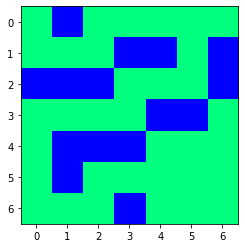

In [185]:
Num_epochs = 200                         # Policy evaluation
gamma = 0.2
plan_size = 7
plan =np.ones((plan_size, plan_size))    # 1:free; 0: barrier
plan[0, 1] = 0
plan[1, [3, 4, 6]] = 0
plan[2, [0, 1, 2, 6]] = 0
plan[3, [4, 5]] = 0
plan[4, [1,2,3]] = 0
plan[5, 1] = 0
plan[6, 3] = 0
start_State = [0, 0]
terminal_state = np.array([3, 6])          # Terminal state   np.max(all_states, axis=0)
plt.imshow(plan, cmap='winter')            # 'winter', 'prism', 'spring'

In [186]:
all_states = np.array((np.where(plan.T==1)[1], np.where(plan.T==1)[0]))
all_states = all_states.T
all_actions = np.array([[1, 0],[-1, 0],[0, 1],[0, -1]])       # Down(1) Up(2) Right(3) Left(4)

***Iterative policy evaluation (Stochastic policy evaluation)***
*Input $\pi$, the policy to be evaluated*
*Algorithm parameter: a small threshold $\theta > 0$ determining accuracy of estimation*
*Initialize V(s), for all $s\epsilon S^+$, arbitrarily expect that $V(terminal) = 0$*
*Loop:*
  $\Delta \leftarrow 0$
  *Loop for each $s\epsilon S$*
  $\nu \leftarrow V(s)$
  $V(s) \leftarrow \sum_{a}\pi(a|s).\sum_{s^.,r}p(s^.,r|s,a)[r+\lambda V_{\pi}(s^.)]$;     *Bellman equation for the State-value function*
  $\Delta \leftarrow max(\Delta,|\nu-V(s)|)$
  *until* $\Delta < \theta$

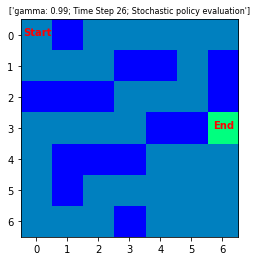

In [231]:
# ======================================== Step 1:Initialization =======================================
gamma = 0.99
V = np.zeros((np.size(all_states, 0)))
policy = (1 / all_actions.shape[0]) * np.ones((all_actions.shape[0], 1))
# ====================================== Step 2:Policy Evaluation =======================================
for i in range(0, Num_epochs):
    v = np.copy(V)

    for j in range(0,np.size(all_states, 0)):
        if (all_states[j, :]==terminal_state).all():
            continue
        Sum = 0
        for k in range(0, np.size(all_actions, 0)):
            [new_state, reward] = environment(all_states, all_states[j,:], all_actions[k,:], terminal_state)   # Environment
            ind = np.argmax(np.sum(np.equal(all_states, new_state),axis=1))
            Sum = Sum +  policy[k]*(reward + gamma*V[ind])
        V[j] = Sum
    if np.linalg.norm(V-v) < 1e-4:
        break
# print(f"Number epochs:{i}")
# ===================================== Step 3:Policy Improvement =======================================
policy = np.zeros((np.size(all_states, 0), 1), dtype=int)   # Policy improvement: selection of the best action; Down(1) Up(2) Right(3) Left(4)
for j in range(0,np.size(all_states , 0)):
    vector = np.zeros((np.size(all_actions , 0),1))
    for k in range(0, np.size(all_actions , 0)):
        [new_state, reward] = environment (all_states, all_states[j,:], all_actions[k,:], terminal_state)   # Environment
        ind = np.argmax(np.sum(np.equal( all_states, new_state),axis=1))
        vector[k] = reward + gamma*V[ind]
    ind = np.where(vector==np.max(vector))[0]
    policy[j] = ind[np.random.randint(low=0, high=len(ind), size=1)]
states, rewards, actions = plot(plan, policy, gamma, type='Stochastic policy evaluation')

***Deterministic policy evaluation***
$\pi_0$  $\underrightarrow{E}$  $\nu_{\pi_0}$  $\underrightarrow{I}$  $\pi_1$ $\underrightarrow{E} ... \underrightarrow{I}$ $\pi_*$  $\underrightarrow{E}$  $\nu_*$
**1. Initialization:**
$V(s)\epsilon R$ *and* $\pi(s) \epsilon A(s)$ *arbitrarily for all $ s \epsilon S$*
**2. Policy Evaluation:**
*Loop:*
  $\Delta \leftarrow 0$
  *Loop for each $s\epsilon S$*
  $\nu \leftarrow V(s)$
  $V(s) \leftarrow \sum_{s^.,r}p(s^.,r|s,\pi(s))[r+\lambda V_{\pi}(s^.)]$
  $\Delta \leftarrow max(\Delta,|\nu-V(s)|)$
  *until* $\Delta < \theta$ *(a small positive number determining the accuracy of estimation)*
**3. Policy Improvement:**
*policy_stable* $\leftarrow$ *true(1)*
*For each* $s \epsilon S$:
  old_action $\leftarrow \pi(s)$
  $\pi(s) \leftarrow argmax_a \sum_{s^.,r}p(s^.,r|s,a)[r+\lambda V_{\pi}(s^.)]$
  *If old_action* $\neq \pi(s)$, *then policy_stable* $\leftarrow false(0)$
*If policy_stable, then stop and return* $V \approx \nu_*$  *and*  $\pi \approx \pi_*$; *else go to 2*

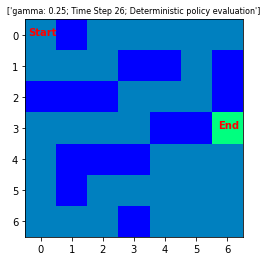

In [233]:
# ======================================== Step 1:Initialization =======================================
gamma = 0.25
V = np.zeros((np.size(all_states,0)))
policy = np.random.randint(low=0, high=all_actions.shape[0], size=all_states.shape[0])
P = 100              # Policy iteration

for p in range(0, P):
# ====================================== Step 2:Policy Evaluation =======================================
    for i in range(0, Num_epochs):
        v = np.copy(V)
        for j in range(0, np.size(all_states, 0)):
            if (all_states[j, :] == terminal_state).all():
                continue

            [new_state, reward] = environment(all_states, all_states[j, :], all_actions[policy[j].item(), :], terminal_state)  # Environment
            ind = np.argmax(np.sum(np.equal(all_states, new_state), axis=1))
            V[j] = reward + gamma*V[ind]

        if np.linalg.norm(V - v) < 1e-4:
            break
# ===================================== Step 3:Policy Improvement =======================================
    policy = np.zeros((all_states.shape[0], 1), dtype=int)
    for r in range(0, np.size(all_states, 0)):
        vector = np.zeros((np.size(all_actions, 0), 1))
        for k in range(0, np.size(all_actions, 0)):
            [new_state2, reward2] = environment(all_states, all_states[r, :], all_actions[k, :], terminal_state)  # Environment
            ind = np.argmax(np.sum(np.equal(all_states, new_state2), axis=1))
            vector[k] = reward2 + gamma * V[ind]
        ind2 = np.where(vector == np.max(vector))[0]
        policy[r] = ind2[np.random.randint(low=0, high=len(ind2), size=1)]
print(f"Number epochs:{p}")
states, rewards, actions = plot(plan, policy, gamma, type='Deterministic policy evaluation')

***Value Iteration***
*Algorithm parameter: a small threshold $\theta > 0$ determining accuracy of estimation*
*Initialize V(s), for all $s\epsilon S^+$, arbitrarily expect that $V(terminal) = 0$*
*Loop:*
  $\Delta \leftarrow 0$
  *Loop for each $s\epsilon S$*
  $\nu \leftarrow V(s)$
  $V(s) \leftarrow max_a \sum_{s^.,r}p(s^.,r|s,a)[r+\lambda V(s^.)]$
  $\Delta \leftarrow max(\Delta,|\nu-V(s)|)$
  *until* $\Delta < \theta$
  *Output a deterministic policy,* $\pi \approx \pi_*$, *such that*
  $\pi(s) = argmax_a \sum_{s^.,r}p(s^.,r|s,a)[r+\lambda V(s^.)]$

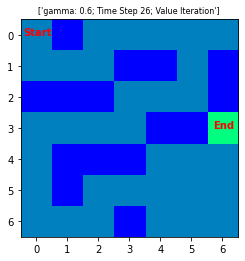

In [238]:
# ======================================== Step 1:Initialization =======================================
gamma = 0.6
V = np.zeros((np.size(all_states,0)))
for i in range(0, Num_epochs):
    v = np.copy(V)
# ====================================== Step 2:Policy Evaluation =======================================
    for j in range(0, np.size(all_states, 0)-1):
        vector = np.zeros((np.size(all_actions, 0), 1))

        for k in range(0, np.size(all_actions, 0)):
            [new_state, reward] = environment(all_states, all_states[j, :], all_actions[k, :], terminal_state)  # Environment
            ind = np.argmax(np.sum(np.equal(all_states, new_state), axis=1))
            vector[k] = reward + gamma * V[ind]
        V[j] = np.max(vector)
    if np.linalg.norm(V - v) < 1e-4:
        break
# print(f"Number epochs:{i}")
# ===================================== Step 3:Policy Improvement =======================================
policy = np.zeros((np.size(all_states, 0), 1), dtype=int)  # Policy improvement: selection of the best action; Down(1) Up(2) Right(3) Left(4)
for j in range(0, np.size(all_states, 0)):
    vector = np.zeros((np.size(all_actions, 0), 1))
    for k in range(0, np.size(all_actions, 0)):
        [new_state, reward] = environment(all_states, all_states[j, :], all_actions[k, :], terminal_state)  # Environment
        ind = np.argmax(np.sum(np.equal(all_states, new_state), axis=1))
        vector[k] = reward + gamma * V[ind]
    ind = np.where(vector == np.max(vector))[0]
    policy[j] = ind[np.random.randint(low=0, high=len(ind), size=1)]
states, rewards, actions = plot(plan, policy, gamma, type='Value Iteration')

***Factored Markov Decision Processes (FMDPs):***
$p(s^.,r|s,a)=Pr[S_t=s^., R_t=r|S_{t-1}=s, A_{t-1}=a]=\sum_{r\epsilon R}p(s^.,r|s,a) \rightarrow [0,1]$
$r(s,a)=E[R_t|S_{t-1}=s, A_{t-1}=a]=\sum_{r\epsilon R}r \sum_{s^.\epsilon S}p(s^.,r|s,a)$
$r(s,a,s^.)=E[R_t|S_{t-1}=s, A_{t-1}=a,S_t=s^.]=\sum_{r\epsilon R}r$ ${p(s^.,r|s,a)} \over{p(s^.|s,a)}$
***Return G equation***
$G_t = r_{t+1}+\lambda r_{t+2}+\lambda^2r_{t+3}+... = \sum_{j=0}^T \lambda^jr_{t+j+1}=r_{t+1}+\lambda(G_{t+1})$;  *t=time step*
***V-function: the value of the state***
$V_{\pi}(s) = E_{\pi}[G_t|s=s_t] = E_{\pi}[\sum_{j=0}^T \lambda^jr_{t+j+1}|s=s_t]$
***Q-function: The value of the action***
$Q_{\pi}(s, a) = E_{\pi}[G_t|S_t=s, A_t=a] = E_{\pi}[\sum_{j=0}^T \lambda^jr_{t+j+1}|St=s, A_t=a]$
***Bellman equation for the State-value function***
$V_{\pi}(s) = \sum_{a}\pi(a|s).\sum_{s^.}P_{ss^.}^a(r(s,a)+\lambda V_{\pi}(s.))= \sum_{a}\pi(a|s).\sum_{s^.,r}p(s^.,r|s,a)[r+\lambda V_{\pi}(s^.)]$
***Bellman equation for the Action-value function***
$Q_{\pi}(s, a) = \sum_{s^.}P_{ss^.}^a(r(s,a)+\lambda.\sum_{a.}\pi(a^.|s^.).Q_{\pi}(s^., a^.)) = \sum_{s^.}P_{ss^.}^a(r(s,a)+\lambda  V_{\pi}(s^.))$
***Bellman equation of optimality***
$V_*(s) = max_a\sum_{s^.}P_{ss^.}^a(r(s,a)+\lambda V_*(s^.))$
$Q_*(s, a) = \sum_{s^.}P_{ss^.}^a(r(s,a)+\lambda max_{a^.}Q_*(s^.,a^.))$